In [2]:
#The aim of this to create, based on a simple sample of the REE and AEMET data, provide a quick MVP that can help to understand data and the project
#We are going into several techonolgies to see if we can predict the production based on meteo data

In [3]:
import pandas as pd
import numpy as np
import requests as requests
from pandas import to_datetime
import seaborn as sns
import matplotlib.pyplot as plt

# 1. SOLAR

### Generation

In [4]:
#First of all, we try to create a model for solar energy with 2014 data that we can extrapolate afterwards
generation_2014 = pd.read_csv('./Data/Generation/Generation_2014.csv')

In [5]:
#We use info or head fucntions to take a quick view on data
generation_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       6314 non-null   float64
 1   percentage  6314 non-null   float64
 2   datetime    6314 non-null   object 
 3   Type        6314 non-null   object 
dtypes: float64(2), object(2)
memory usage: 197.4+ KB


In [6]:
generation_2014.head()

,value,percentage,datetime,Type
0,73065.052,0.110822,2014-01-01T00:00:00.000+01:00,Hidráulica
1,89171.545,0.120605,2014-01-02T00:00:00.000+01:00,Hidráulica
2,102502.527,0.137045,2014-01-03T00:00:00.000+01:00,Hidráulica
3,106840.706,0.142476,2014-01-04T00:00:00.000+01:00,Hidráulica
4,117217.635,0.168658,2014-01-05T00:00:00.000+01:00,Hidráulica


In [7]:
#In order to have a 'cleaner' datetime and to order it by datetime:

generation_2014['fecha'] = generation_2014['datetime'].str[:10]
generation_2014['fecha'] = pd.to_datetime(generation_2014['fecha'])
generation_2014 = generation_2014.sort_values(by = 'fecha', ignore_index = True)
generation_2014.head()

,value,percentage,datetime,Type,fecha
0,73065.0520,0.110822,2014-01-01T00:00:00.000+01:00,Hidráulica,2014-01-01
1,4616.7525,0.007003,2014-01-01T00:00:00.000+01:00,Residuos no renovables,2014-01-01
2,146015.5030,0.221470,2014-01-01T00:00:00.000+01:00,Nuclear,2014-01-01
3,54043.0770,0.081970,2014-01-01T00:00:00.000+01:00,Cogeneración,2014-01-01
4,25240.6550,0.038284,2014-01-01T00:00:00.000+01:00,Carbón,2014-01-01


In [8]:
#As we can see there are two types of solar techonology: termo & fotov
generation_2014['Type'].unique()

array(['Hidráulica', 'Residuos no renovables', 'Nuclear', 'Cogeneración',
       'Carbón', 'Fuel + Gas', 'Otras renovables', 'Residuos renovables',
       'Motores diésel', 'Turbina de gas', 'Solar térmica',
       'Generación total', 'Turbina de vapor', 'Solar fotovoltaica',
       'Ciclo combinado', 'Turbinación bombeo', 'Eólica', 'Hidroeólica'],
      dtype=object)

In [9]:
#At this point we are only interested in solar, therefore:
solar_2014 = generation_2014[(generation_2014['Type'] == 'Solar térmica') | (generation_2014['Type'] == 'Solar fotovoltaica')]
solar_2014.groupby('Type').describe()


value                                                   \
                    count          mean           std       min        25%   
Type                                                                         
Solar fotovoltaica  365.0  22487.468852   8003.948206  3836.442  15782.954   
Solar térmica       365.0  13586.068290  10571.075479     3.768   3598.560   

                                                    percentage            \
                          50%        75%        max      count      mean   
Type                                                                       
Solar fotovoltaica  23719.051  30115.854  34761.032      365.0  0.031230   
Solar térmica       11950.145  24239.508  32305.953      365.0  0.018978   

                                                                                
                         std       min       25%       50%       75%       max  
Type                                                                            
Solar fotovoltaica  0.011873  0.005189  0.021117  0.032837  0.041233  0.059202  
Solar térmica       0.014974  0.000005  0.005069  0.016540  0.033121  0.050830

### WeatherData

As a first naive approach, we will consider an average of the conditions with main impact per day. 
First we will calculate the mean for the 'provincia' for each day, and then the whole mean in order to not give more weight to the provincias with 
more stations.

In [10]:

#Let's prepare now the weather data
weather_2014 = pd.read_csv('./Data/Weather/Weather2014.csv')
weather_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        92888 non-null  object 
 1   indicativo   92888 non-null  object 
 2   nombre       92888 non-null  object 
 3   provincia    92888 non-null  object 
 4   altitud      92888 non-null  int64  
 5   tmed         89480 non-null  object 
 6   prec         88915 non-null  object 
 7   tmin         89484 non-null  object 
 8   horatmin     87598 non-null  object 
 9   tmax         89506 non-null  object 
 10  horatmax     87800 non-null  object 
 11  dir          83078 non-null  float64
 12  velmedia     84451 non-null  object 
 13  racha        83081 non-null  object 
 14  horaracha    83071 non-null  object 
 15  sol          49713 non-null  object 
 16  presMax      67974 non-null  object 
 17  horaPresMax  67970 non-null  object 
 18  presMin      67973 non-null  object 
 19  hora

In [11]:
#We downloaded also the metadata from the API request to a better understanding of the variables:
weather_metadata = pd.read_csv('./Data/Weather/Metadata.csv')
weather_metadata

,Unnamed: 0,id,descripcion,tipo_datos,unidad,requerido
0,0,fecha,fecha del dia (AAAA-MM-DD),string,NaN,True
1,0,indicativo,indicativo climatológico,string,NaN,True
2,0,nombre,nombre (ubicación) de la estación,string,NaN,True
3,0,provincia,provincia de la estación,string,NaN,True
4,0,altitud,altitud de la estación en m sobre el nivel del...,float,m,True
5,0,tmed,Temperatura media diaria,float,°C,False
6,0,prec,Precipitación diaria de 07 a 07,float,"mm (Ip = inferior a 0,1 mm) (Acum = Precipitac...",False
7,0,tmin,Temperatura Mínima del día,float,°C,False
8,0,horatmin,Hora y minuto de la temperatura mínima,string,UTC,False
9,0,tmax,Temperatura Máxima del día,float,°C,False


In [12]:
#how many stations per province are there?
stations = weather_2014.groupby('provincia')['nombre'].nunique()
stations

provincia
A CORUÑA                  9
ALBACETE                  4
ALICANTE                  4
ALMERIA                   6
ARABA/ALAVA               2
ASTURIAS                 10
AVILA                     3
BADAJOZ                   6
BARCELONA                 7
BIZKAIA                   5
BURGOS                    5
CACERES                   6
CADIZ                     7
CANTABRIA                 6
CASTELLON                 4
CEUTA                     1
CIUDAD REAL               5
CORDOBA                   4
CUENCA                    4
GIPUZKOA                  6
GIRONA                    4
GRANADA                   6
GUADALAJARA               4
HUELVA                    4
HUESCA                    5
ILLES BALEARS            10
JAEN                      7
LA RIOJA                  1
LAS PALMAS               10
LEON                      5
LLEIDA                    5
LUGO                      1
MADRID                   13
MALAGA                    6
MELILLA                   1
MURCIA    

In [13]:
#'SOL' would be the most interesting to use in this case. We are including 'tmed' and'tmax' also as solar production does not work properly with with temperatures.

weather_2014_solar = weather_2014[['fecha', 'nombre', 'provincia','prec','tmed', 'tmax', 'sol']]
weather_2014_solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha      92888 non-null  object
 1   nombre     92888 non-null  object
 2   provincia  92888 non-null  object
 3   prec       88915 non-null  object
 4   tmed       89480 non-null  object
 5   tmax       89506 non-null  object
 6   sol        49713 non-null  object
dtypes: object(7)
memory usage: 5.0+ MB


In [14]:
#There are many null values in sol, we should eliminate those values

weather_2014_solar_clean = weather_2014_solar.dropna()
weather_2014_solar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48516 entries, 0 to 92885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha      48516 non-null  object
 1   nombre     48516 non-null  object
 2   provincia  48516 non-null  object
 3   prec       48516 non-null  object
 4   tmed       48516 non-null  object
 5   tmax       48516 non-null  object
 6   sol        48516 non-null  object
dtypes: object(7)
memory usage: 3.0+ MB


In [15]:
def transform_columns(columns):
    for column in columns:
        weather_2014_solar_clean[column] = weather_2014_solar_clean[column].str.replace(',', '.')
        weather_2014_solar_clean[column] = weather_2014_solar_clean[column].apply(pd.to_numeric)


In [16]:
cols = ['tmed', 'tmax', 'sol']
transform_columns(cols)

/tmp/ipykernel_7633/4165096179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_2014_solar_clean[column] = weather_2014_solar_clean[column].str.replace(',', '.')
/tmp/ipykernel_7633/4165096179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_2014_solar_clean[column] = weather_2014_solar_clean[column].apply(pd.to_numeric)


In [17]:
weather_2014_solar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48516 entries, 0 to 92885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      48516 non-null  object 
 1   nombre     48516 non-null  object 
 2   provincia  48516 non-null  object 
 3   prec       48516 non-null  object 
 4   tmed       48516 non-null  float64
 5   tmax       48516 non-null  float64
 6   sol        48516 non-null  float64
dtypes: float64(3), object(4)
memory usage: 3.0+ MB


In [18]:
#Let's see how that affects to our data
weather_2014_solar_clean.describe()

,tmed,tmax,sol
count,48516.000000,48516.000000,48516.000000
mean,15.773708,20.999697,7.109692
std,6.644418,7.646067,4.135653
min,-7.900000,-5.400000,0.000000
25%,10.900000,15.300000,3.600000
50%,16.100000,21.200000,7.800000
75%,20.800000,26.800000,10.500000
max,33.700000,42.900000,14.900000


In [19]:
stations2 = weather_2014_solar_clean.groupby('provincia')['nombre'].nunique()
stations2

provincia
A CORUÑA                 5
ALBACETE                 2
ALICANTE                 3
ALMERIA                  2
ARABA/ALAVA              2
ASTURIAS                 6
AVILA                    1
BADAJOZ                  5
BARCELONA                3
BIZKAIA                  1
BURGOS                   4
CACERES                  3
CADIZ                    3
CANTABRIA                2
CASTELLON                2
CEUTA                    1
CIUDAD REAL              3
CORDOBA                  1
CUENCA                   2
GIPUZKOA                 3
GIRONA                   2
GRANADA                  4
GUADALAJARA              3
HUELVA                   1
HUESCA                   1
ILLES BALEARS            6
JAEN                     3
LA RIOJA                 1
LAS PALMAS               3
LEON                     4
LLEIDA                   2
LUGO                     1
MADRID                   6
MALAGA                   2
MELILLA                  1
MURCIA                   6
NAVARRA           

In [20]:
#We calculate now the mean for the main variables that we are going to use in our calculations for each day
solar_pivot_table = weather_2014_solar_clean.groupby(['fecha', 'provincia'], as_index=False)[['tmed', 'tmax', 'sol']].mean()
solar_pivot_table = solar_pivot_table.groupby('fecha', as_index = False)[['tmed', 'tmax', 'sol']].mean()
solar_pivot_table

,fecha,tmed,tmax,sol
0,2014-01-01,9.550357,12.799144,2.119574
1,2014-01-02,11.654574,14.214551,0.782418
2,2014-01-03,12.360114,15.082482,2.165994
3,2014-01-04,9.566809,13.703086,2.431548
4,2014-01-05,8.840096,12.976809,3.286621
...,...,...,...,...
360,2014-12-27,7.848739,12.021447,3.379085
361,2014-12-28,7.093889,11.311550,3.631190
362,2014-12-29,4.379505,8.897479,7.334328
363,2014-12-30,4.315686,10.123931,7.566732


In [21]:
#In order to be able to mix it with generation data, we need to adapt 'fecha' field
solar_pivot_table['fecha']=solar_pivot_table['fecha'].apply(to_datetime)

In [22]:
solar_pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   365 non-null    datetime64[ns]
 1   tmed    365 non-null    float64       
 2   tmax    365 non-null    float64       
 3   sol     365 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.5 KB


### Complete solar data

We already have the information we need from weather data and production data.It is time to mix it

In [23]:
solar_model = pd.merge(solar_2014 , solar_pivot_table, how = 'inner', on = 'fecha')
solar_model

,value,percentage,datetime,Type,fecha,tmed,tmax,sol
0,519.532,0.000788,2014-01-01T00:00:00.000+01:00,Solar térmica,2014-01-01,9.550357,12.799144,2.119574
1,7631.801,0.011576,2014-01-01T00:00:00.000+01:00,Solar fotovoltaica,2014-01-01,9.550357,12.799144,2.119574
2,177.784,0.000240,2014-01-02T00:00:00.000+01:00,Solar térmica,2014-01-02,11.654574,14.214551,0.782418
3,3836.442,0.005189,2014-01-02T00:00:00.000+01:00,Solar fotovoltaica,2014-01-02,11.654574,14.214551,0.782418
4,8673.179,0.011596,2014-01-03T00:00:00.000+01:00,Solar fotovoltaica,2014-01-03,12.360114,15.082482,2.165994
...,...,...,...,...,...,...,...,...
725,20378.527,0.026683,2014-12-29T00:00:00.000+01:00,Solar fotovoltaica,2014-12-29,4.379505,8.897479,7.334328
726,20306.808,0.027071,2014-12-30T00:00:00.000+01:00,Solar fotovoltaica,2014-12-30,4.315686,10.123931,7.566732
727,9051.317,0.012066,2014-12-30T00:00:00.000+01:00,Solar térmica,2014-12-30,4.315686,10.123931,7.566732
728,8714.433,0.012068,2014-12-31T00:00:00.000+01:00,Solar térmica,2014-12-31,5.766713,12.803296,7.625341


In [24]:
solar_model['Type']= solar_model['Type'].astype('string')
solar_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   value       730 non-null    float64       
 1   percentage  730 non-null    float64       
 2   datetime    730 non-null    object        
 3   Type        730 non-null    string        
 4   fecha       730 non-null    datetime64[ns]
 5   tmed        730 non-null    float64       
 6   tmax        730 non-null    float64       
 7   sol         730 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1), string(1)
memory usage: 51.3+ KB


In [25]:
#We are goint to create two different datasets to analyze separately each energy source
solar_termo = solar_model[solar_model['Type'] == 'Solar térmica'].reset_index().drop(columns = 'index')
solar_foto = solar_model[solar_model['Type'] == 'Solar fotovoltaica'].reset_index().drop(columns = 'index')

### Data Visualization

### Solar Termo

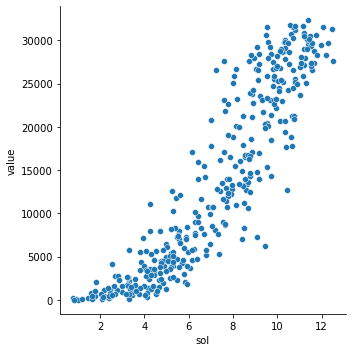

In [26]:

sns.relplot(data = solar_termo , x = 'sol', y = 'value')

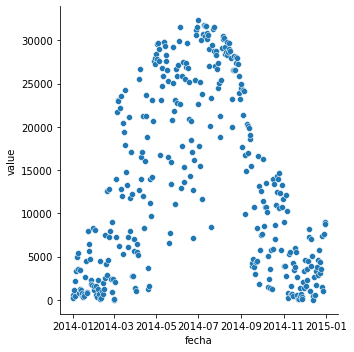

In [27]:
sns.relplot(data = solar_termo , x = 'fecha', y = 'value')

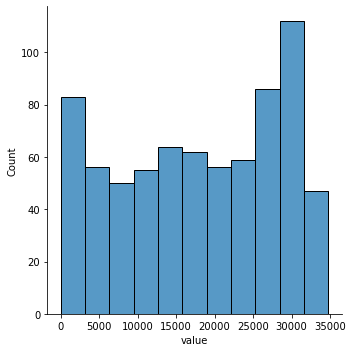

In [28]:
sns.displot(solar_model['value'])

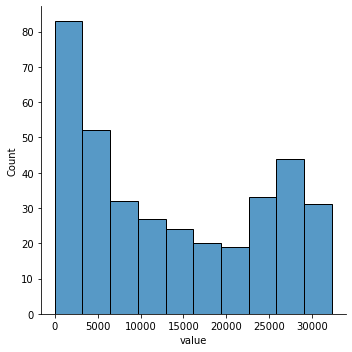

In [29]:
sns.displot(solar_termo['value'])

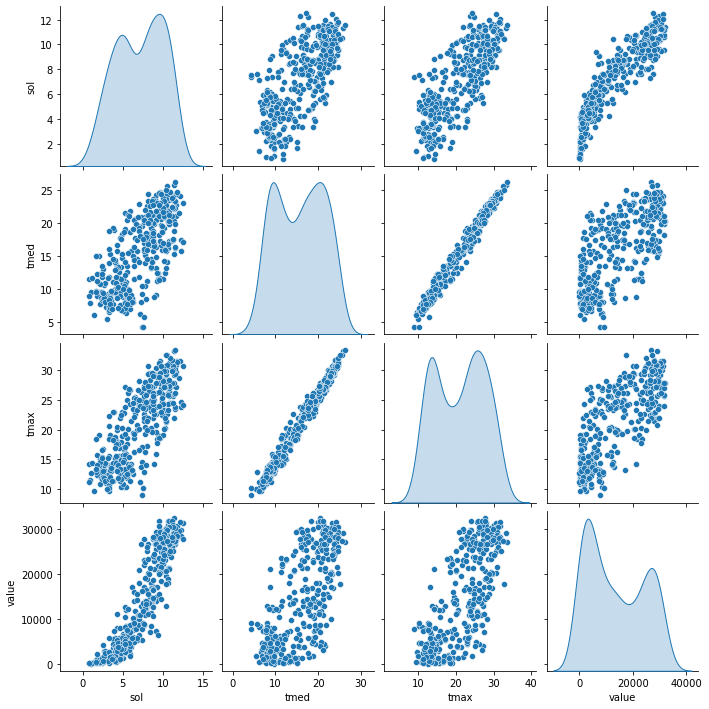

In [30]:
sns.pairplot(solar_termo[['sol', 'tmed', 'tmax', 'value']],diag_kind='kde')

In [31]:
#IN order to see both energy resources at the same time
solar_model_melt = pd.melt(solar_model, id_vars = 'Type', value_vars=['sol', 'tmed', 'tmax', 'value'])
sns.pairplot(solar_model_melt[['sol', 'tmed', 'tmax', 'value']], diag_kind = 'hist', hue = 'Type')

/home/dsc/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


KeyError: "['sol', 'tmed', 'tmax'] not in index"

### Solar Foto

<AxesSubplot:xlabel='value', ylabel='Count'>

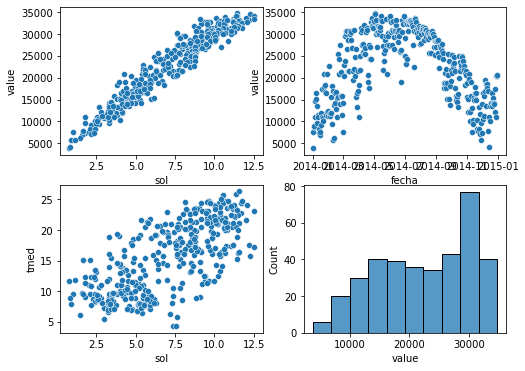

In [ ]:
#Only figure plots from sns work with plt.subplot
ig, axes = plt.subplots(2,2, figsize = (8,6))
sns.scatterplot(ax = axes[0,0], data = solar_foto , x = 'sol', y = 'value')
sns.scatterplot(ax = axes[0,1], data = solar_foto , x = 'fecha', y = 'value')
sns.scatterplot(ax = axes[1,0], data = solar_foto , x = 'sol', y = 'tmed')
sns.histplot(ax = axes[1,1], data = solar_foto['value'])

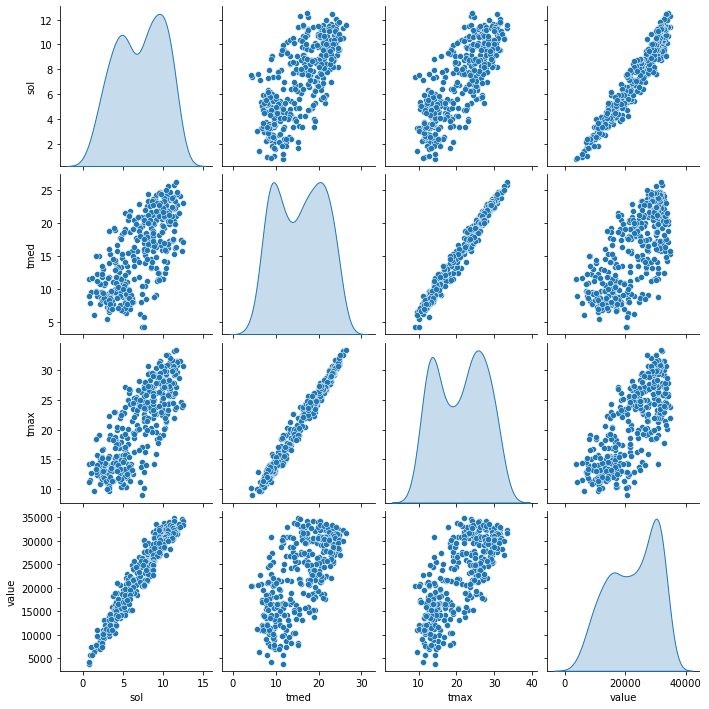

In [ ]:
sns.pairplot(solar_foto[['sol', 'tmed', 'tmax', 'value']],diag_kind='kde')

# Create ML Model

In [32]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

### Solar Termo

In [33]:
solar_termo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   value       365 non-null    float64       
 1   percentage  365 non-null    float64       
 2   datetime    365 non-null    object        
 3   Type        365 non-null    string        
 4   fecha       365 non-null    datetime64[ns]
 5   tmed        365 non-null    float64       
 6   tmax        365 non-null    float64       
 7   sol         365 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1), string(1)
memory usage: 22.9+ KB


In [34]:
solar_termo.head()

,value,percentage,datetime,Type,fecha,tmed,tmax,sol
0,519.532,0.000788,2014-01-01T00:00:00.000+01:00,Solar térmica,2014-01-01,9.550357,12.799144,2.119574
1,177.784,0.000240,2014-01-02T00:00:00.000+01:00,Solar térmica,2014-01-02,11.654574,14.214551,0.782418
2,1157.242,0.001547,2014-01-03T00:00:00.000+01:00,Solar térmica,2014-01-03,12.360114,15.082482,2.165994
3,478.934,0.000639,2014-01-04T00:00:00.000+01:00,Solar térmica,2014-01-04,9.566809,13.703086,2.431548
4,2137.221,0.003075,2014-01-05T00:00:00.000+01:00,Solar térmica,2014-01-05,8.840096,12.976809,3.286621


In [35]:
#We are going to create the model based on linear regression first
#Transform dataframe objects to numpy is needed to be able to reshape the data afterwards

X_termo = solar_termo[['sol', 'tmed']].to_numpy()
y_termo = solar_termo['value'].to_numpy()



In [41]:
def lr_model (X,y):

    #Estimator would be LR from sklearn

    reg = LinearRegression()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)
    y = y.reshape(-1,1)

    print(X.shape)
    print(y.shape)

    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
    print(f'Model intercept is {reg.intercept_}')
    print(f'Model coefficient is {reg.coef_}')
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [37]:
#Let's check how the model works

lr_model(X_termo, y_termo)

(365, 2)
(365, 1)
Model intercept is [-11028.705398]
Model coefficient is [[2940.69857205  241.14108825]]
Model MAE is 3193.0
Model MSE is 16325822.0
Model r2 is 0.862
Model RMSE is 4041.0
CV mean is 0.523 and std is 0.201


array([[-2492.6931312 ],
       [-5917.4544308 ],
       [-1678.63968766],
       [-1571.30614797],
       [  767.96633488],
       [ 4645.66873158],
       [ 6200.81821418],
       [ 6958.15414141],
       [ 3175.00740626],
       [  994.03851583],
       [ 2400.73553642],
       [ 1485.48722801],
       [-1881.93023747],
       [-3575.31722175],
       [-3958.56313014],
       [-2133.21933069],
       [ 1844.41366203],
       [-2744.21375619],
       [   73.48094145],
       [ 5664.29261049],
       [ -542.9944744 ],
       [-1845.72698931],
       [ 7211.14567835],
       [ 5779.12868517],
       [ 5061.75431869],
       [ 7676.57251178],
       [ 4900.9194087 ],
       [  319.81751259],
       [  101.77280903],
       [ 6387.48561071],
       [ -737.75033847],
       [  521.7977744 ],
       [11554.63342388],
       [ -837.98970101],
       [  805.18434485],
       [ 3434.0521883 ],
       [ 6390.41679101],
       [ 7254.66520765],
       [ -859.67284952],
       [-6418.5165341 ],


In [38]:
# The function also draws and small and simple plot to a better understanding and analysis of the model performance.
plt.scatter(X,y)
plt.scatter(X_test, y_test, c = 'green')
plt.scatter(X, reg.intercept_ + reg.coef_ * X, c = 'red')


NameError: name 'X' is not defined

In [42]:
#Let's check now if the model improves if we standarize data

X_termo_log = np.log(X_termo)
y_termo_log = np.log(y_termo)

lr_model(X_termo_log , y_termo_log)

#It seems that the model it's working better! We should transform the predictions again if we want to use it later

(365, 2)
(365, 1)
Model intercept is [4.19553598]
Model coefficient is [[2.43881737 0.08683165]]
Model MAE is 0.37
Model MSE is 0.34
Model r2 is 0.872
Model RMSE is 0.58
CV mean is 0.567 and std is 0.363


array([[ 6.22355512],
       [ 3.81036381],
       [ 6.29878316],
       [ 6.55858523],
       [ 7.28661911],
       [ 8.04459653],
       [ 8.30784587],
       [ 8.42446456],
       [ 7.78032518],
       [ 7.31067829],
       [ 7.63956105],
       [ 7.43265408],
       [ 6.5447049 ],
       [ 5.80919877],
       [ 5.54771472],
       [ 6.42234902],
       [ 7.59007534],
       [ 6.26954966],
       [ 7.22491163],
       [ 8.34343349],
       [ 7.02226421],
       [ 6.54859232],
       [ 8.55335187],
       [ 8.30293881],
       [ 8.08422289],
       [ 8.54019984],
       [ 8.1471773 ],
       [ 7.24909924],
       [ 7.21653247],
       [ 8.46744879],
       [ 6.8703954 ],
       [ 7.26368856],
       [ 9.15784274],
       [ 7.03263498],
       [ 7.3793319 ],
       [ 7.84393294],
       [ 8.32061722],
       [ 8.53676105],
       [ 6.80802572],
       [ 4.17506009],
       [ 8.17456051],
       [ 5.24228409],
       [ 7.49408345],
       [ 8.08712793],
       [ 8.25526382],
       [ 7

In [48]:
#Let's try with another way of standirzing data with StandardScaler:
#Standardize features by removing the mean and scaling to unit variance.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

shapetermo = X_termo.shape[1]
X_termo_sc = X_termo.reshape(-1,shapetermo)
y_termo_sc = y_termo.reshape(-1,1)

X_termo_scaler = scaler.fit_transform(X_termo_sc)
y_termo_scaler = scaler.fit_transform(y_termo_sc)

In [49]:
lr_model(X_termo_scaler, y_termo_scaler)

(365, 2)
(365, 1)
Model intercept is [-2.29507109e-17]
Model coefficient is [[0.82258894 0.12781512]]
Model MAE is 0.33
Model MSE is 0.16
Model r2 is 0.828
Model RMSE is 0.4
CV mean is 0.523 and std is 0.201


array([[-1.52310259],
       [-1.84752204],
       [-1.44598926],
       [-1.43582181],
       [-1.21422813],
       [-0.84690266],
       [-0.69958707],
       [-0.62784645],
       [-0.98621488],
       [-1.19281285],
       [-1.05955981],
       [-1.14625909],
       [-1.46524649],
       [-1.62565698],
       [-1.66196095],
       [-1.4890505 ],
       [-1.11225885],
       [-1.54692854],
       [-1.28001506],
       [-0.75041085],
       [-1.33841231],
       [-1.46181704],
       [-0.60388116],
       [-0.73953271],
       [-0.80748786],
       [-0.55979239],
       [-0.82272337],
       [-1.25668019],
       [-1.27733504],
       [-0.68190451],
       [-1.35686106],
       [-1.23754708],
       [-0.19243296],
       [-1.3663565 ],
       [-1.21070255],
       [-0.96167619],
       [-0.68162685],
       [-0.59975866],
       [-1.36841049],
       [-1.89498645],
       [-0.84086612],
       [-1.79144369],
       [-1.14092318],
       [-0.78656443],
       [-0.68413079],
       [-1

### Solar Foto

In [51]:
#Fristly, we are going to create the model based on linear regression first
#Transform dataframe objects to numpy is needed to be able to reshape the data afterwards
#Let's see how it works with the same variables as for termo

X_foto = solar_foto[['sol', 'tmed']].to_numpy()
y_foto = solar_foto['value'].to_numpy()

#We use also de log standarization

X_foto_log = np.log(X_foto)
y_foto_log = np.log(y_foto)

#And the standardscaler stand.

scaler = StandardScaler()

shapefoto = X_foto.shape[1]
X_foto_sc = X_foto.reshape(-1,shapefoto)
y_foto_sc = y_foto.reshape(-1,1)

X_foto_scaler = scaler.fit_transform(X_foto_sc)
y_foto_scaler = scaler.fit_transform(y_foto_sc)

In [61]:
lr_model(X_foto, y_foto)


(365, 2)
(365, 1)
Model intercept is [3947.81119186]
Model coefficient is [[2608.07087404    3.26117476]]
Model MAE is 1489.79
Model MSE is 3217833.07
Model r2 is 0.952
Model RMSE is 1793.83
CV mean is 0.73 and std is 0.183


array([[ 9506.95624882],
       [ 6026.419303  ],
       [ 9637.18447992],
       [10320.65875067],
       [12548.38047912],
       [15600.50147776],
       [16912.1397781 ],
       [17536.30467318],
       [14427.75798161],
       [12613.90450503],
       [13860.37745234],
       [13057.9738803 ],
       [10312.57721809],
       [ 8650.38490161],
       [ 8166.65592219],
       [ 9992.33935217],
       [13724.58884948],
       [ 9646.61048314],
       [12416.87641115],
       [17312.46052503],
       [11716.46206686],
       [10319.887408  ],
       [18432.44592949],
       [16975.97773983],
       [15756.05198881],
       [18200.27874772],
       [16164.8168011 ],
       [12469.10435053],
       [12374.65392392],
       [18036.9083409 ],
       [11202.17888206],
       [12493.45009923],
       [22659.46668536],
       [11819.532156  ],
       [12943.79538239],
       [14713.12762408],
       [16958.15569272],
       [18283.74610452],
       [11010.04768085],
       [ 6376.4886537 ],


In [64]:
np.exp(lr_model(X_foto_log, y_foto_log))


(365, 2)
(365, 1)
Model intercept is [8.39128979]
Model coefficient is [[0.77041812 0.04826903]]
Model MAE is 0.07
Model MSE is 0.01
Model r2 is 0.948
Model RMSE is 0.1
CV mean is 0.748 and std is 0.19


array([[ 8768.86326426],
       [ 4108.40045303],
       [ 9028.13582327],
       [ 9748.15924106],
       [12248.66276487],
       [15623.80633764],
       [16989.11886448],
       [17634.12230589],
       [14354.40075349],
       [12360.12528446],
       [13713.49872192],
       [12844.57663038],
       [ 9676.75222425],
       [ 7684.5420408 ],
       [ 7086.0152801 ],
       [ 9320.38898341],
       [13445.41522362],
       [ 8860.40621567],
       [11937.00390581],
       [17011.88076612],
       [11221.49810092],
       [ 9691.48840216],
       [18239.39639381],
       [16888.9059044 ],
       [15850.54040623],
       [18286.41796049],
       [16083.71549598],
       [12057.15993256],
       [11917.29309593],
       [17669.6825773 ],
       [10740.83634679],
       [12137.00277309],
       [21962.20607822],
       [11194.66779116],
       [12555.93119294],
       [14637.62552427],
       [17076.07471647],
       [18183.79128308],
       [10540.92107713],
       [ 4572.64114526],


In [63]:
lr_model(X_foto_scaler, y_foto_scaler)


(365, 2)
(365, 1)
Model intercept is [7.87541845e-17]
Model coefficient is [[0.96353312 0.00228297]]
Model MAE is 0.17
Model MSE is 0.05
Model r2 is 0.947
Model RMSE is 0.22
CV mean is 0.73 and std is 0.183


array([[-1.62398986],
       [-2.05943929],
       [-1.60769703],
       [-1.52218767],
       [-1.24347776],
       [-0.86162739],
       [-0.69752853],
       [-0.61943936],
       [-1.00834914],
       [-1.23528006],
       [-1.07933403],
       [-1.17972261],
       [-1.52319875],
       [-1.73115537],
       [-1.79167462],
       [-1.56326366],
       [-1.09632252],
       [-1.60651774],
       [-1.25993022],
       [-0.64744447],
       [-1.34755894],
       [-1.52228418],
       [-0.50732327],
       [-0.68954177],
       [-0.84216649],
       [-0.53636967],
       [-0.79102599],
       [-1.25339599],
       [-1.26521266],
       [-0.55680892],
       [-1.41190083],
       [-1.25035009],
       [ 0.02151862],
       [-1.33466386],
       [-1.19400747],
       [-0.97264659],
       [-0.69177149],
       [-0.52592708],
       [-1.43593833],
       [-2.01564216],
       [-0.76140434],
       [-1.84702279],
       [-1.14637424],
       [-0.8443542 ],
       [-0.74204743],
       [-1